In [7]:
import polars as pl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path
import os,gc

In [8]:
path = Path('/media/my_disk/data/mgtv/Data_A/')
 # 'did_features'
 # 'vid_info'
 # '弹幕文本数据',
 # '用户历史播放数据'
 # '用户历史曝光数据'
 # '用户历史点击数据'
 # 'A榜待预测的did'
 # 'A榜用户曝光数据'

In [20]:
def read_log_data(data_type='view',day=1,read_type='read'):
    
    
    data_path = path 
    
    # data_path = path
    
    if day<10:
        date = '0'+str(day)
    else:
        date = str(day)
    
    if data_type == 'view':
        data_path = data_path / '用户历史曝光数据'/ f'day{date}' / f'did_show_data{date}.csv'
    elif data_type == 'click':
         data_path = data_path /'用户历史点击数据'/ f'day{date}' / f'day{date}_data.csv'
    elif data_type == 'play':
        data_path = data_path /'用户历史播放数据'/ f'day{date}' / f'day{date}_data.csv'
    else:
        raise NameError(f'no such data type "{data_type}"')
        
    if read_type=='read':
        return pl.read_csv(data_path)
    elif read_type=='scan':
        return pl.scan_csv(data_path)
    else:
        raise NameError(f'no such read type "{data_type}"')

def scan_log_data():
    scan_data_all  = {'view':{},'click':{},'play':{}}

    for day_i in range(1,31):
        scan_data_all['view'][day_i] =  read_log_data(data_type='view',day=day_i,read_type='scan')
        scan_data_all['click'][day_i] =  read_log_data(data_type='click',day=day_i,read_type='scan')
        scan_data_all['play'][day_i] =  read_log_data(data_type='play',day=day_i,read_type='scan')
    return scan_data_all

In [30]:
scan_data = scan_log_data()

In [33]:
vid_data = pl.read_csv(path/'vid_info/vid_info_table.csv')

# 完播率分布

In [92]:
plt.figure(figsize=(16, 16), dpi=500)

for day_i in range(1,31):
    
    plt.subplot(6,5,day_i)
    
    scan_data['play'][day_i].collect().join(vid_data.select('vid','item_duration'),how='left',on='vid')\
    .with_columns((pl.col('play_time')/pl.col('item_duration')).alias('play_ratio'))\
    ['play_ratio'].hist(bins=[i/10 for i in range(0,11)]).to_pandas().set_index('breakpoint')['count'].plot(title=f'day {day_i} play_ratio')
plt.tight_layout()
plt.show()

# vid、did的overlap

<AxesSubplot:title={'center':'view_vid_overlap_by_day'}>

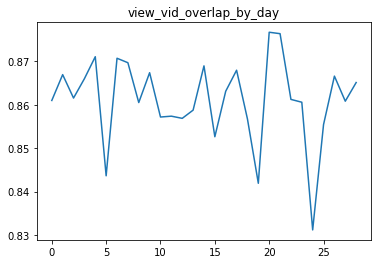

In [125]:
# 与过去一天
view_overlap = np.ones((29,2))
for i in range(1,30):
    view_overlap[i-1,0] = scan_data['view'][i].select('vid').unique()\
    .join(scan_data['view'][i+1].select('vid').unique(),on='vid',how='inner').collect().shape[0]
    view_overlap[i-1,1] = scan_data['view'][i+1].select('vid').unique().collect().shape[0]
view_overlap = pd.DataFrame(view_overlap,columns=['overlap_cnt','cnt'])
view_overlap['over_ratio'] = view_overlap['overlap_cnt']/view_overlap['cnt']
view_overlap['over_ratio'].plot(title='view_vid_overlap_by_day')

<AxesSubplot:title={'center':'click_vid_overlap_by_day'}>

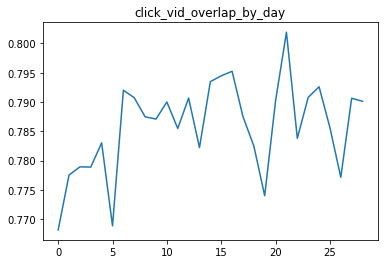

In [126]:
# 与过去一天
click_overlap = np.ones((29,2))
for i in range(1,30):
    click_overlap[i-1,0] = scan_data['click'][i].select('vid').unique()\
    .join(scan_data['click'][i+1].select('vid').unique(),on='vid',how='inner').collect().shape[0]
    click_overlap[i-1,1] = scan_data['click'][i+1].select('vid').unique().collect().shape[0]
click_overlap = pd.DataFrame(click_overlap,columns=['overlap_cnt','cnt'])
click_overlap['over_ratio'] = click_overlap['overlap_cnt']/click_overlap['cnt']
click_overlap['over_ratio'].plot(title='click_vid_overlap_by_day')

<AxesSubplot:title={'center':'play_vid_overlap_by_day'}>

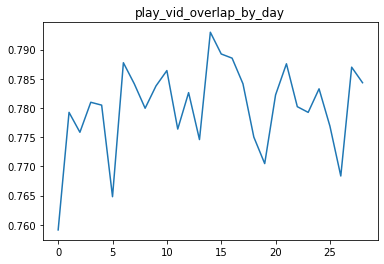

In [127]:
# 与过去一天
play_overlap = np.ones((29,2))
for i in range(1,30):
    play_overlap[i-1,0] = scan_data['play'][i].select('vid').unique()\
    .join(scan_data['play'][i+1].select('vid').unique(),on='vid',how='inner').collect().shape[0]
    play_overlap[i-1,1] = scan_data['play'][i+1].select('vid').unique().collect().shape[0]
play_overlap = pd.DataFrame(play_overlap,columns=['overlap_cnt','cnt'])
play_overlap['over_ratio'] = play_overlap['overlap_cnt']/play_overlap['cnt']
play_overlap['over_ratio'].plot(title='play_vid_overlap_by_day')

<AxesSubplot:title={'center':'view_vid_overlap_by_day'}>

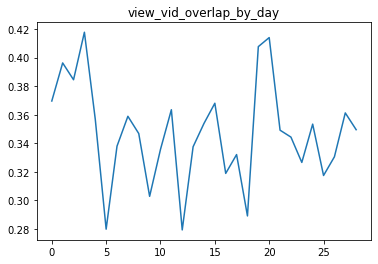

In [130]:
# 用户
did_overlap = np.ones((29,2))
for i in range(1,30):
    did_overlap[i-1,0] = scan_data['view'][i].select('did').unique()\
    .join(scan_data['view'][i+1].select('did').unique(),on='did',how='inner').collect().shape[0]
    did_overlap[i-1,1] = scan_data['view'][i+1].select('did').unique().collect().shape[0]
did_overlap = pd.DataFrame(did_overlap,columns=['overlap_cnt','cnt'])
did_overlap['over_ratio'] = did_overlap['overlap_cnt']/did_overlap['cnt']
did_overlap['over_ratio'].plot(title='view_vid_overlap_by_day')

<AxesSubplot:title={'center':'did active day'}, xlabel='category'>

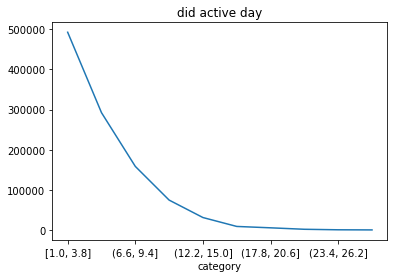

In [150]:
# 用户活跃天数
did_by_day = [scan_data['view'][i].select('did').unique().with_columns(pl.lit(i).alias('day')) for i in range(1,31)]
pl.concat(did_by_day).group_by('did').n_unique().collect()['day'].hist().to_pandas().set_index('category')['count'].plot(title='did active day')

<AxesSubplot:title={'center':'view_vid_overlap_by_past_n_day'}>

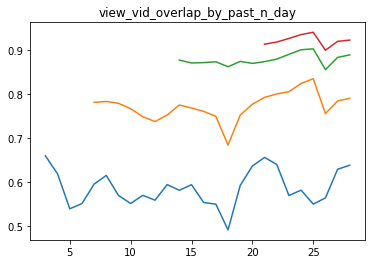

In [184]:
# 当天用户与过去n天的用户重合度

diff_day = 3
did_overlap = np.ones((29,2))
for i in range(diff_day,30):
    # print([i-j for j in range(diff_day)],i+1)
    did_overlap[i-1,0] = pl.concat([scan_data['view'][i-j].select('did').unique() for j in range(diff_day)]).select('did').unique()\
    .join(scan_data['view'][i+1].select('did').unique(),on='did',how='inner').collect().shape[0]
    did_overlap[i-1,1] = scan_data['view'][i+1].select('did').unique().collect().shape[0]
did_overlap = pd.DataFrame(did_overlap,columns=['overlap_cnt','cnt'])
did_overlap['over_ratio'] = did_overlap['overlap_cnt']/did_overlap['cnt']
did_overlap['over_ratio'].iloc[diff_day:].plot(title=f'view_vid_overlap_by_past_n_day')


diff_day = 7
did_overlap = np.ones((29,2))
for i in range(diff_day,30):
    # print([i-j for j in range(diff_day)],i+1)
    did_overlap[i-1,0] = pl.concat([scan_data['view'][i-j].select('did').unique() for j in range(diff_day)]).select('did').unique()\
    .join(scan_data['view'][i+1].select('did').unique(),on='did',how='inner').collect().shape[0]
    did_overlap[i-1,1] = scan_data['view'][i+1].select('did').unique().collect().shape[0]
did_overlap = pd.DataFrame(did_overlap,columns=['overlap_cnt','cnt'])
did_overlap['over_ratio'] = did_overlap['overlap_cnt']/did_overlap['cnt']
did_overlap['over_ratio'].iloc[diff_day:].plot(title=f'view_vid_overlap_by_past_n_day')

diff_day = 14
did_overlap = np.ones((29,2))
for i in range(diff_day,30):
    # print([i-j for j in range(diff_day)],i+1)
    did_overlap[i-1,0] = pl.concat([scan_data['view'][i-j].select('did').unique() for j in range(diff_day)]).select('did').unique()\
    .join(scan_data['view'][i+1].select('did').unique(),on='did',how='inner').collect().shape[0]
    did_overlap[i-1,1] = scan_data['view'][i+1].select('did').unique().collect().shape[0]
did_overlap = pd.DataFrame(did_overlap,columns=['overlap_cnt','cnt'])
did_overlap['over_ratio'] = did_overlap['overlap_cnt']/did_overlap['cnt']
did_overlap['over_ratio'].iloc[diff_day:].plot(title=f'view_vid_overlap_by_past_n_day')

diff_day = 21
did_overlap = np.ones((29,2))
for i in range(diff_day,30):
    # print([i-j for j in range(diff_day)],i+1)
    did_overlap[i-1,0] = pl.concat([scan_data['view'][i-j].select('did').unique() for j in range(diff_day)]).select('did').unique()\
    .join(scan_data['view'][i+1].select('did').unique(),on='did',how='inner').collect().shape[0]
    did_overlap[i-1,1] = scan_data['view'][i+1].select('did').unique().collect().shape[0]
did_overlap = pd.DataFrame(did_overlap,columns=['overlap_cnt','cnt'])
did_overlap['over_ratio'] = did_overlap['overlap_cnt']/did_overlap['cnt']
did_overlap['over_ratio'].iloc[diff_day:].plot(title=f'view_vid_overlap_by_past_n_day')

In [187]:
# 测试集
over_lap_test = pl.concat([scan_data['view'][30-j].select('did').unique() for j in range(7)]).select('did').unique()\
    .join(pl.scan_csv(path/'A榜待预测的did/testA_pred_did.csv').select('did').unique(),on='did',how='inner').collect().shape[0]\
/pl.scan_csv(path/'A榜待预测的did/testA_pred_did.csv').select('did').unique().collect().shape[0]
print('测试集 & 过去7天 用户重合度：', over_lap_test)

over_lap_test = pl.concat([scan_data['view'][30-j].select('did').unique() for j in range(14)]).select('did').unique()\
    .join(pl.scan_csv(path/'A榜待预测的did/testA_pred_did.csv').select('did').unique(),on='did',how='inner').collect().shape[0]\
/pl.scan_csv(path/'A榜待预测的did/testA_pred_did.csv').select('did').unique().collect().shape[0]
print('测试集 & 过去14天 用户重合度：', over_lap_test)

over_lap_test = pl.concat([scan_data['view'][30-j].select('did').unique() for j in range(21)]).select('did').unique()\
    .join(pl.scan_csv(path/'A榜待预测的did/testA_pred_did.csv').select('did').unique(),on='did',how='inner').collect().shape[0]\
/pl.scan_csv(path/'A榜待预测的did/testA_pred_did.csv').select('did').unique().collect().shape[0]
print('测试集 & 过去21天 用户重合度：', over_lap_test)

测试集 & 过去7天 用户重合度： 0.6611128604201341
测试集 & 过去14天 用户重合度： 0.7654446493635014
测试集 & 过去21天 用户重合度： 0.7987404975034861


In [ ]:
# 测试集的冷启动用户更多！！！